<a href="https://colab.research.google.com/github/romiaprilian7406/sp500-fair-value/blob/gColab/notebooks/sp500_fair_value.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Libraries

In [122]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import warnings

# Modeling & Preprocessing
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.preprocessing import RobustScaler, FunctionTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin

# Models
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

# Metrics
from sklearn.metrics import mean_absolute_percentage_error, r2_score

# Global Configurations

In [123]:
warnings.filterwarnings('ignore')
pd.set_option('display.float_format', lambda x: '%.2f' % x)
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

# Load Data

In [124]:
dataset_url = 'https://raw.githubusercontent.com/romiaprilian7406/sp500-fair-value/refs/heads/main/data/sp500_fv_dataset.csv'

try:
  df = pd.read_csv(dataset_url)
  print(f"Berhasil connect ke {dataset_url}")
except Exception as e:
  print(f"Gagal connect: {e}")

Berhasil connect ke https://raw.githubusercontent.com/romiaprilian7406/sp500-fair-value/refs/heads/main/data/sp500_fv_dataset.csv


# EDA

## Missing Values

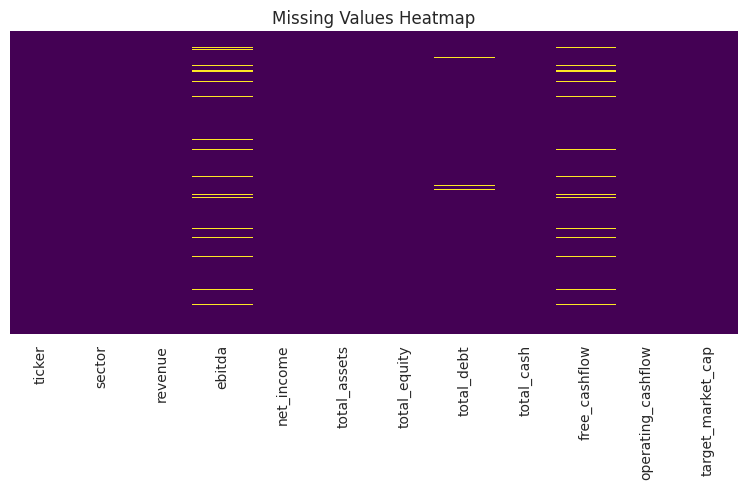


Fitur dengan Missing Values:
ebitda           5.58%
free_cashflow    5.18%
total_debt       0.80%
dtype: object


In [125]:
# 1. Visualisasi Missing Values
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
sns.heatmap(df.isnull(), cbar=False, cmap='viridis', yticklabels=False)
plt.title('Missing Values Heatmap')
plt.tight_layout()
plt.show()

# Menampilkan persentase missing value
missing = df.isnull().sum()
missing = missing[missing > 0]
if not missing.empty:
    print("\nFitur dengan Missing Values:")
    print((missing / len(df) * 100).sort_values(ascending=False).map('{:.2f}%'.format))
else:
    print("\nTidak ada Missing Values.")

## Distribution of Target

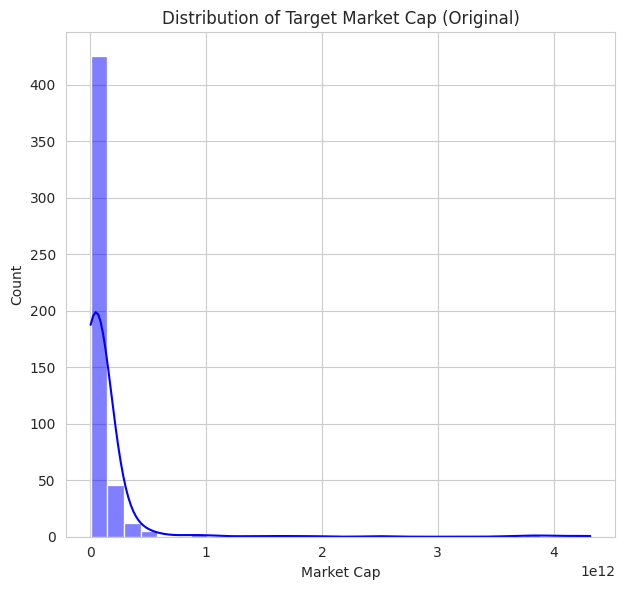

In [126]:
# Distribusi Target (Market Cap)
plt.subplot(1, 2, 2)
sns.histplot(df['target_market_cap'], bins=30, kde=True, color='blue')
plt.title('Distribution of Target Market Cap (Original)')
plt.xlabel('Market Cap')

plt.tight_layout()
plt.show()

## Outliers

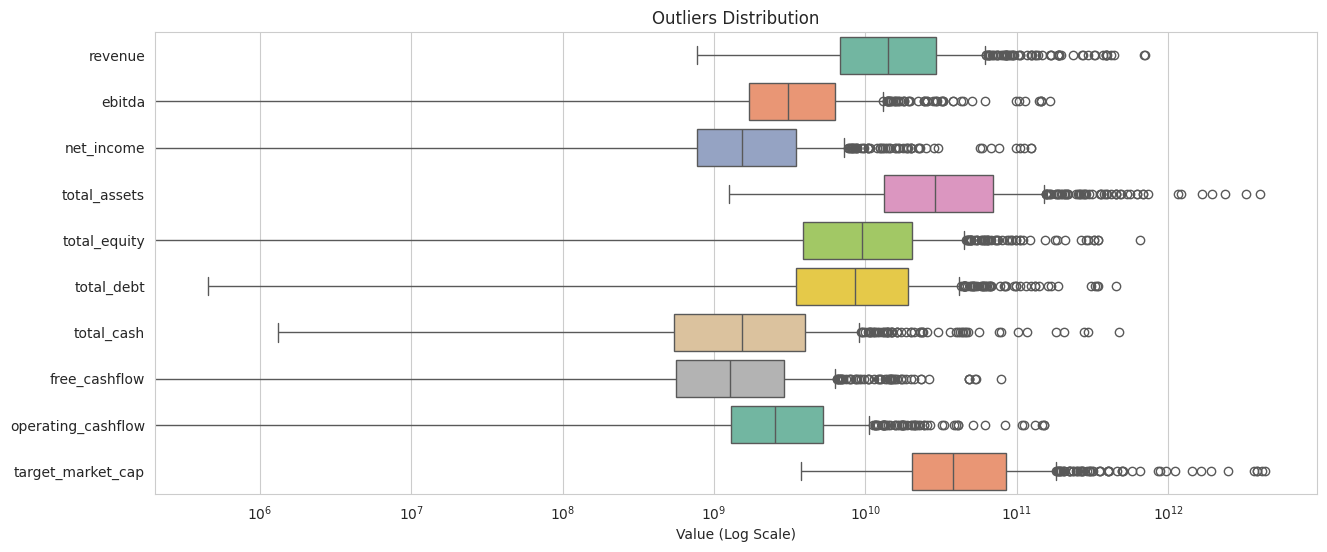

In [127]:
# Pilih kolom numerik untuk analisis
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
# Buang target dari fitur input
feature_cols = [c for c in numeric_cols if c != 'target_market_cap']

# 1. Boxplot untuk Outliers (Top 5 Fitur Utama)
plt.figure(figsize=(15, 6))
sns.boxplot(data=df[numeric_cols], orient='h', palette="Set2")
plt.title('Outliers Distribution')
plt.xscale('log') # Menggunakan log scale agar boxplot terlihat jelas
plt.xlabel('Value (Log Scale)')
plt.show()

## Correlation Heatmap

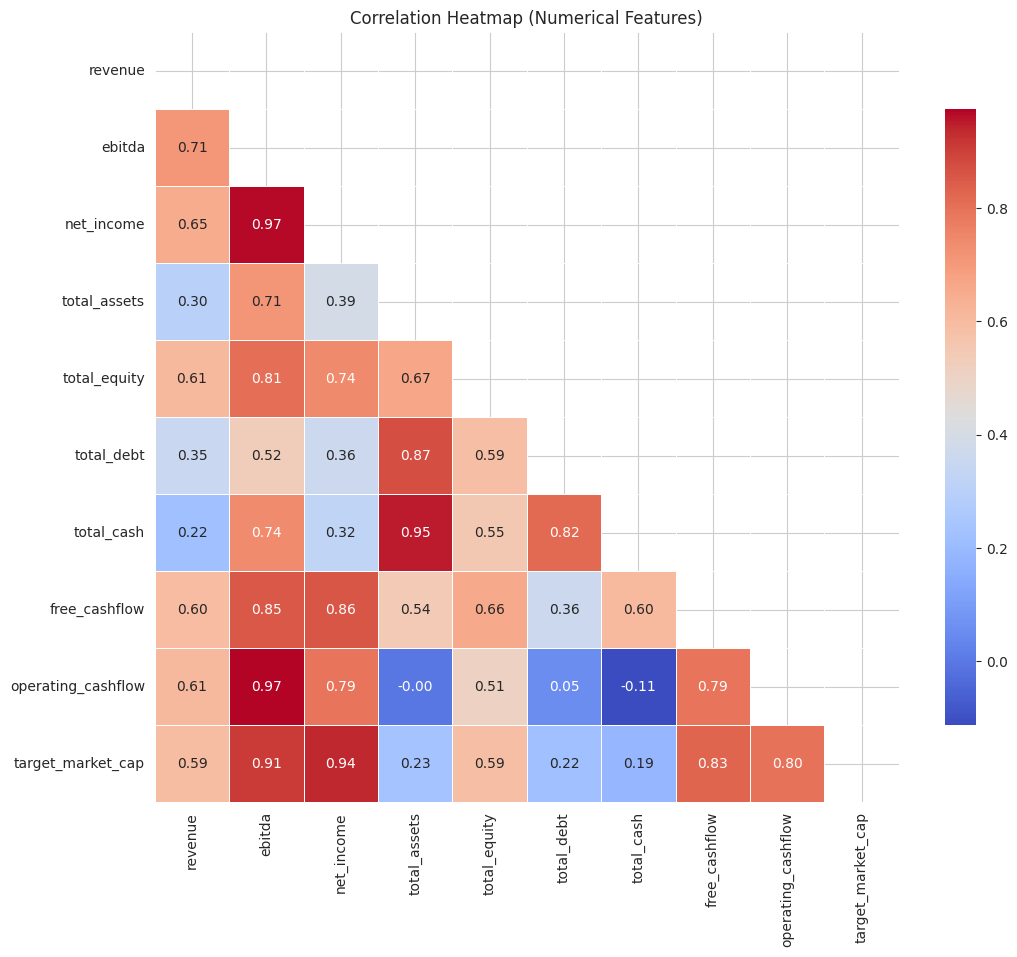

In [128]:
# Correlation Heatmap
plt.figure(figsize=(12, 10))
corr_matrix = df[numeric_cols].corr()
mask = np.triu(np.ones_like(corr_matrix, dtype=bool)) # Masker segitiga atas

sns.heatmap(corr_matrix, mask=mask, annot=True, fmt=".2f", cmap='coolwarm',
            linewidths=0.5, cbar_kws={"shrink": .8})
plt.title('Correlation Heatmap (Numerical Features)')
plt.show()

# Feature Engineering

In [129]:
# Signed Log Transformation untuk menangani skewness ekstrem pada data finansial (seperti Market Cap) dan menangani nilai negatif pada Net Income tanpa menghapus data
# Transformasi logaritma yang aman untuk nilai negatif
# Rumus: sign(x) * log(1 + |x|)
def signed_log_transform(x):
    return np.sign(x) * np.log1p(np.abs(x))

# Mengembalikan nilai dari skala Log ke skala asli (Dollar)
# Rumus: sign(x) * (exp(|x|) - 1)
def signed_log_inverse(x):
    return np.sign(x) * np.expm1(np.abs(x))

In [130]:
# 1. Pisahkan Fitur & Target
# Hapus 'sector' agar model bersifat universal (tidak bias terhadap sektor tertentu)
X = df.drop(['ticker', 'sector', 'target_market_cap'], axis=1)
y = df['target_market_cap']

# 2. Transformasi Target secara Manual
# (Diperlukan karena pipeline sklearn biasanya hanya mentransformasi X, bukan y)
y_log = signed_log_transform(y)

# 3. Pembagian Data (Stratified Split)
# Menggunakan 'sector' untuk stratifikasi guna memastikan pembagian yang seimbang antar sektor,
X_train, X_test, y_train, y_test = train_test_split(
    X, y_log,
    test_size=0.2,
    random_state=42,
    stratify=df['sector']
)

print(f"Train Shape : {X_train.shape}")
print(f"Test Shape  : {X_test.shape}")

Train Shape : (401, 9)
Test Shape  : (101, 9)


# Preprocessing Pipeline Construction

In [131]:
# 1. Create Pipeline
log_transformer = FunctionTransformer(signed_log_transform, validate=False)

numeric_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('log_transform', log_transformer),
    ('scaler', RobustScaler())
])

# 2. Define Model
# Gradient Boosting dengan Loss Function Absolute Error untuk meminimalkan MAPE dan mengurangi sensitivitas terhadap outlier perusahaan raksasa (Mega Caps)
model = GradientBoostingRegressor(
        n_estimators=100,
        max_depth=3,
        learning_rate=0.05,
        min_samples_split=10,
        min_samples_leaf=5,
        subsample=0.8,
        random_state=42
)

full_pipeline = Pipeline([
    ('preprocessor', numeric_pipeline),
    ('model', model)
])

# 3. Train
full_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 Pipeline(steps=[('imputer', SimpleImputer(strategy='median')),
                                 ('log_transform',
                                  FunctionTransformer(func=<function signed_log_transform at 0x7ab49b579120>)),
                                 ('scaler', RobustScaler())])),
                ('model',
                 GradientBoostingRegressor(learning_rate=0.05,
                                           min_samples_leaf=5,
                                           min_samples_split=10,
                                           random_state=42, subsample=0.8))])

# Training & Evaluation

In [132]:
# 1. Prediksi pada Data Train dan Test (Masih dalam Log Scale)
y_train_pred_log = full_pipeline.predict(X_train)
y_test_pred_log = full_pipeline.predict(X_test)

# 2. Kembalikan ke Skala Asli ($) menggunakan Inverse Transform
# Pastikan fungsi signed_log_inverse sudah didefinisikan sebelumnya
y_train_pred = signed_log_inverse(y_train_pred_log)
y_train_true = signed_log_inverse(y_train)

y_test_pred = signed_log_inverse(y_test_pred_log)
y_test_true = signed_log_inverse(y_test)

# 3. Hitung Metrik Evaluasi
# MAPE (dikalikan 100 agar jadi persen)
train_mape = mean_absolute_percentage_error(y_train_true, y_train_pred) * 100
test_mape = mean_absolute_percentage_error(y_test_true, y_test_pred) * 100

# R2 Score
train_r2 = r2_score(y_train_true, y_train_pred)
test_r2 = r2_score(y_test_true, y_test_pred)

# 4. Hitung Gap (Selisih Absolut) untuk Deteksi Overfitting
gap_mape = abs(test_mape - train_mape)
gap_r2 = abs(test_r2 - train_r2)

# 5. Buat DataFrame Summary
evaluation_data = {
    'model': ['Gradient Boosting'],
    'train MAPE (%)': [train_mape],
    'test MAPE (%)': [test_mape],
    'gap MAPE (%)': [gap_mape],
    'train R2': [train_r2],
    'test R2': [test_r2],
    'gap R2': [gap_r2]
}

df_results = pd.DataFrame(evaluation_data)

display(df_results)

,model,train MAPE (%),test MAPE (%),gap MAPE (%),train R2,test R2,gap R2
0,Gradient Boosting,31.52,37.33,5.81,0.81,0.78,0.03


# Feature Importance

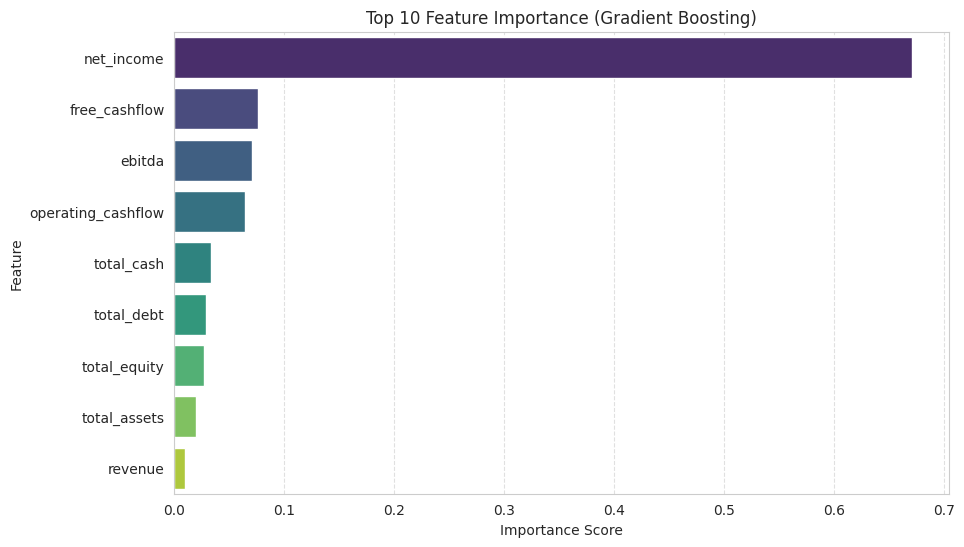


Top 10 Features:
           Feature  Importance
        net_income        0.67
     free_cashflow        0.08
            ebitda        0.07
operating_cashflow        0.06
        total_cash        0.03
        total_debt        0.03
      total_equity        0.03
      total_assets        0.02
           revenue        0.01


In [133]:
# Ambil objek model dari dalam pipeline
# Nama step model di pipeline adalah 'model'
trained_model = full_pipeline.named_steps['model']

if hasattr(trained_model, 'feature_importances_'):
    # Ambil feature names dari X_train
    feature_names = X_train.columns
    importances = trained_model.feature_importances_

    # Buat DataFrame
    fi_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})

    # Sortir dari yang terpenting
    fi_df = fi_df.sort_values(by='Importance', ascending=False).head(10)

    # Plot
    plt.figure(figsize=(10, 6))
    sns.barplot(x='Importance', y='Feature', data=fi_df, palette='viridis')
    plt.title('Top 10 Feature Importance (Gradient Boosting)')
    plt.xlabel('Importance Score')
    plt.ylabel('Feature')
    plt.grid(axis='x', linestyle='--', alpha=0.6)
    plt.show()

    # Print text version
    print("\nTop 10 Features:")
    print(fi_df.to_string(index=False))
else:
    print("Model ini tidak mendukung feature importance")

# Visualization

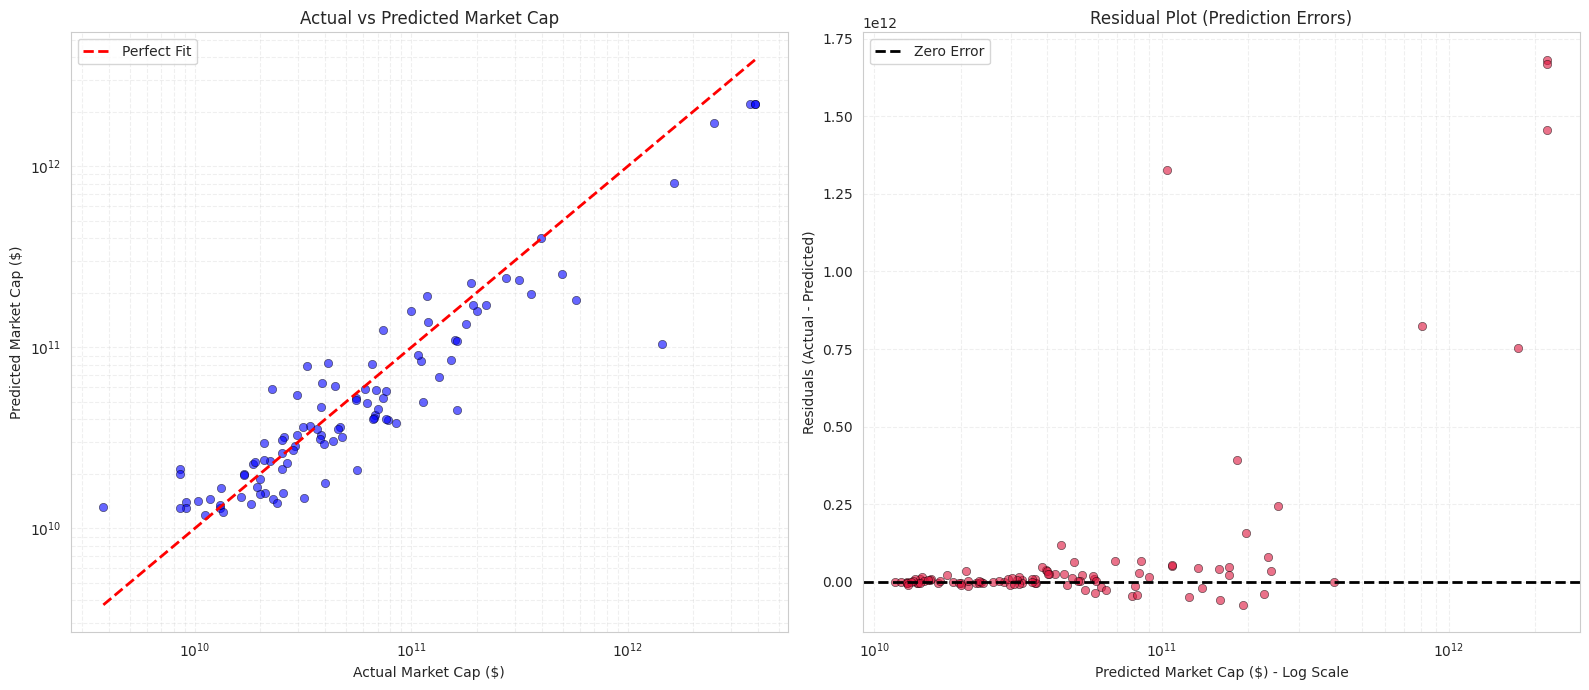

In [134]:
# 1. Generate Prediksi
# Gunakan full_pipeline karena preprocessor ada di dalamnya
# Input adalah X_test (data mentah), bukan X_test_processed
y_pred_log = full_pipeline.predict(X_test)

# 2. Kembalikan ke Skala Asli ($)
# Gunakan signed_log_inverse agar konsisten
y_test_real = signed_log_inverse(y_test)
y_pred_real = signed_log_inverse(y_pred_log)

# 3. Hitung Residuals
residuals = y_test_real - y_pred_real

# 4. Visualisasi
plt.figure(figsize=(16, 7))

# Plot 1: Actual vs Predicted
plt.subplot(1, 2, 1)
sns.scatterplot(x=y_test_real, y=y_pred_real, alpha=0.6, color='blue', edgecolor='k')

# Garis Identitas (Perfect Fit)
min_val = min(y_test_real.min(), y_pred_real.min())
max_val = max(y_test_real.max(), y_pred_real.max())
plt.plot([min_val, max_val], [min_val, max_val], 'r--', lw=2, label='Perfect Fit')

plt.title(f'Actual vs Predicted Market Cap')
plt.xlabel('Actual Market Cap ($)')
plt.ylabel('Predicted Market Cap ($)')
plt.xscale('log'); plt.yscale('log') # Log scale
plt.legend()
plt.grid(True, which="both", ls="--", alpha=0.3)

# Plot 2: Residual Plot
plt.subplot(1, 2, 2)
sns.scatterplot(x=y_pred_real, y=residuals, alpha=0.6, color='crimson', edgecolor='k')

# Garis Nol
plt.axhline(0, color='black', linestyle='--', lw=2, label='Zero Error')

plt.title('Residual Plot (Prediction Errors)')
plt.xlabel('Predicted Market Cap ($) - Log Scale')
plt.ylabel('Residuals (Actual - Predicted)')
plt.xscale('log') # X-axis log scale
plt.grid(True, which="both", ls="--", alpha=0.3)
plt.legend()

plt.tight_layout()
plt.show()

# Stock Picking & Analysis

In [135]:
# 1. Ambil kembali Ticker & Sector berdasarkan index y_test
# (Mapping balik dari index data test ke dataframe asli)
test_indices = y_test.index
analysis_df = df.loc[test_indices, ['ticker', 'sector', 'target_market_cap']].copy()

# 2. Masukkan Prediksi & Data Aktual
# - Gunakan 'full_pipeline'
# - Input adalah 'X_test' (mentah), pipeline akan otomatis mengolahnya
# - Gunakan 'signed_log_inverse' agar konsisten dengan transformasi training

analysis_df['Actual_Cap'] = signed_log_inverse(y_test)

# Prediksi (Output Log -> Inverse ke Dollar)
y_pred_log = full_pipeline.predict(X_test)
analysis_df['Predicted_Cap'] = signed_log_inverse(y_pred_log)

# 3. Hitung Potential Upside
# Rumus: (Nilai Wajar Model - Harga Pasar) / Harga Pasar
analysis_df['Potential_Upside'] = (analysis_df['Predicted_Cap'] - analysis_df['Actual_Cap']) / analysis_df['Actual_Cap']

# 4. Filter: Undervalued > 20% (Margin of Safety)
top_picks = analysis_df[analysis_df['Potential_Upside'] > 0.20].sort_values(by='Potential_Upside', ascending=False)

print(f"Ditemukan {len(top_picks)} Saham Potensial (Undervalued > 20%)")
print(f"Saham-saham ini memiliki fundamental yang menyiratkan valuasi lebih tinggi dari harga pasar saat ini\n")

# 5. Display dengan Styling
# Pastikan kolom ada sebelum display
cols_to_show = ['ticker', 'sector', 'Actual_Cap', 'Predicted_Cap', 'Potential_Upside']
styled_picks = top_picks.head(15)[cols_to_show]

display(styled_picks.style.format({
    'Actual_Cap': '${:,.0f}',
    'Predicted_Cap': '${:,.0f}',
    'Potential_Upside': '{:.2%}'
}).background_gradient(subset=['Potential_Upside'], cmap='Greens'))

Ditemukan 26 Saham Potensial (Undervalued > 20%)
Saham-saham ini memiliki fundamental yang menyiratkan valuasi lebih tinggi dari harga pasar saat ini



,ticker,sector,Actual_Cap,Predicted_Cap,Potential_Upside
168,ENPH,Technology,"$3,775,302,656","$13,061,236,445",245.97%
163,EIX,Utilities,"$22,660,110,336","$58,606,191,197",158.63%
117,CAG,Consumer Defensive,"$8,538,576,896","$21,201,474,301",148.30%
460,UAL,Industrials,"$33,008,324,608","$79,007,247,267",139.36%
138,DVA,Healthcare,"$8,557,120,000","$19,963,191,213",133.29%
435,TGT,Consumer Defensive,"$41,177,649,152","$82,013,399,183",99.17%
477,WRB,Financial Services,"$29,523,847,168","$54,189,608,054",83.55%
103,CI,Healthcare,"$74,068,647,936","$124,179,491,757",67.65%
223,HIG,Financial Services,"$38,528,950,272","$63,773,039,413",65.52%
101,CB,Financial Services,"$118,084,091,904","$192,056,116,662",62.64%


# Detailed Accuracy

In [136]:
print("Predicted VS Actual (10 Prediksi Paling Akurat):")
# Tambahkan styling format
display(detailed_view.sort_values('Error_%').head(10).style.format({
    'Actual_B': '${:,.2f} B',
    'Pred_B': '${:,.2f} B',
    'Error_%': '{:.2f}%',
    'Upside': '{:.2%}'
}).background_gradient(subset=['Error_%'], cmap='RdYlGn_r')) # Hijau jika error kecil

print("\nPredicted VS Actual (10 Selisih Terbesar):")
display(detailed_view.sort_values('Error_%', ascending=False).head(10).style.format({
    'Actual_B': '${:,.2f} B',
    'Pred_B': '${:,.2f} B',
    'Error_%': '{:.2f}%',
    'Upside': '{:.2%}'
}).background_gradient(subset=['Error_%'], cmap='Reds')) # Merah jika error besar

Predicted VS Actual (10 Prediksi Paling Akurat):


,ticker,sector,Actual_B,Pred_B,Error_%,Upside
393,REG,Real Estate,$13.09 B,$12.91 B,1.43%,-1.43%
56,BAC,Financial Services,$397.38 B,$404.81 B,1.87%,1.87%
243,IEX,Industrials,$13.09 B,$13.39 B,2.23%,2.23%
185,EXPD,Industrials,$19.94 B,$19.41 B,2.66%,-2.66%
183,EXE,Energy,$29.04 B,$28.21 B,2.87%,-2.87%
29,AWK,Utilities,$25.38 B,$26.11 B,2.88%,2.88%
274,KMI,Energy,$60.78 B,$58.49 B,3.76%,-3.76%
485,WEC,Utilities,$36.46 B,$35.02 B,3.93%,-3.93%
414,SJM,Consumer Defensive,$11.12 B,$11.64 B,4.72%,4.72%
156,DTE,Utilities,$28.46 B,$26.93 B,5.36%,-5.36%



Predicted VS Actual (10 Selisih Terbesar):


,ticker,sector,Actual_B,Pred_B,Error_%,Upside
168,ENPH,Technology,$3.78 B,$13.57 B,259.31%,259.31%
163,EIX,Utilities,$22.66 B,$58.38 B,157.62%,157.62%
117,CAG,Consumer Defensive,$8.54 B,$21.60 B,152.96%,152.96%
138,DVA,Healthcare,$8.56 B,$20.38 B,138.13%,138.13%
460,UAL,Industrials,$33.01 B,$75.97 B,130.15%,130.15%
435,TGT,Consumer Defensive,$41.18 B,$81.84 B,98.75%,98.75%
439,TSLA,Consumer Cyclical,"$1,430.67 B",$101.56 B,92.90%,-92.90%
477,WRB,Financial Services,$29.52 B,$54.29 B,83.88%,83.88%
210,GEV,Industrials,$163.27 B,$44.21 B,72.92%,-72.92%
103,CI,Healthcare,$74.07 B,$124.55 B,68.16%,68.16%


# Production

## Export Model

In [137]:
# Simpan 'full_pipeline' yang sudah dilatih di cell sebelumnya.
# Pipeline ini sudah paket lengkap: Imputer -> SignedLog -> Scaler -> Model

file_name = 'sp500_fv_model.joblib'

model_packet = {
    'pipeline': full_pipeline,  # Simpan pipeline yang sudah di-fit
    'description': 'End-to-End Pipeline with FunctionTransformer',
    'feature_names': list(X.columns), # Simpan nama fitur agar user tahu inputnya apa
    'metrics': {
        'test_mape': test_mape,
        'test_r2': test_r2
    }
}

joblib.dump(model_packet, file_name)

print(f"Model berhasil diekspor ke: {file_name}")
print(f"Isi Packet: {list(model_packet.keys())}")

Model berhasil diekspor ke: sp500_fv_model.joblib
Isi Packet: ['pipeline', 'description', 'feature_names', 'metrics']


## Production & Simulation

In [138]:
# 1. DEFINISI FUNGSI (WAJIB ADA)
# Agar joblib bisa me-load FunctionTransformer, fungsi ini harus didefinisikan
def signed_log_transform(x):
    return np.sign(x) * np.log1p(np.abs(x))

# 2. LOAD MODEL
packet = joblib.load('sp500_fv_model.joblib')
model_pipeline = packet['pipeline']
features = packet['feature_names']

# 3. DATA BARU (Contoh User Input - Data Mentah)
# Pastikan nama key sama persis dengan fitur saat training
new_data = {
    'revenue': 5_000_000_000,      # 5 Miliar
    'ebitda': -100_000_000,        # Rugi 100 Juta
    'net_income': -200_000_000,    # Rugi 200 Juta
    'total_assets': 2_000_000_000,
    'total_equity': 1_000_000_000,
    'total_debt': 500_000_000,
    'total_cash': 300_000_000,
    'free_cashflow': -50_000_000,
    'operating_cashflow': 100_000_000
}

# Ubah ke DataFrame
df_input = pd.DataFrame([new_data])

# Pastikan urutan kolom sesuai
df_input = df_input[features]

# 4. PREDIKSI
# Pipeline otomatis menjalankan: Impute -> SignedLog -> Scale -> Predict
pred_log = model_pipeline.predict(df_input)[0]

# 5. INVERSE TRANSFORM (Manual)
# Karena target (y) tidak masuk pipeline, kembalikan ke Dollar secara manual
pred_value = np.sign(pred_log) * np.expm1(np.abs(pred_log))

print(f"Prediksi Market Cap: ${pred_value:,.2f}")

Prediksi Market Cap: $15,750,865,550.76
